## Effects of selection on LD among loci underlying HCN production

This simulates the effects of selection on LD in the following way:
1. From initial frequency of dominant alleles, calculate the frequency of all 16 possible genotypes assuming HWE.
2. Impose selection on genotypes
3. Calculate gamete frequencies from selected genotypes
4. Calculate LD from gamete frequencies
5. For all generation except the first, new genotype frequencies are calculated from the gamete frequencies above so that each generation of selection genotypes alters gamete frequencies, which alters genotype frequencies, etc...recursively. LD is calculated from gamete frequencies every generation. 

In [1]:
def phenotype(pA, pB):
    '''Calculates the frequency of recessive phenotype

    Modeled based on cyanogenesis system in white clover (T. repens).
    Recessive phenotype regers to phenotype lacking the production of
    hydrogen cyanide. With respect to genotypes, this corresponds to any
    genotype lacking a functional (i.e. dominant, 'A' or 'B') allele at
    either locus. Thus, only A- B- plants produce cyanide.

    Parameters:
    1. pA: Frequency of 'A' allele
    2. pB: Frequency of 'B' allele

    Returns:
    Frequency of recessive (i.e. acyanogenic) phenotype as float.
    '''
    qA = 1 - pA
    qB = 1 - pB
    mut= qA ** 2 + qB ** 2 - (qA ** 2 * qB ** 2)
    WT = 1 - mut
    return mut # Frequency of acyanogenic phenotype


def HW_genotypes(pA, pB, s, h):
    """ Calculates frequency of genotypes from allele frequencies, assuming HW"""
    
    qA = 1 - pA
    qB = 1 - pB
    
    Genotypes = {'AB_AB': [(pA ** 2 * pB ** 2), 1 + h*s],

             'AB_Ab': [(pA ** 2 * pA * qB), 1 + h*s],
             'Ab_AB': [(pA ** 2 * qB * pA), 1 + h*s],

             'AB_aB': [(pA * qA * pB ** 2), 1 + h*s],
             'aB_AB': [(qA * pA * pB ** 2), 1 + h*s],

             'AB_ab': [(pA * pB * qA * qB), 1 + h*s],
             'ab_AB': [(qA * qB * pA * pB), 1 + h*s],

             'Ab_Ab': [(pA ** 2 * qB ** 2), 1],

             'Ab_aB': [(pA * qA * qB * pB), 1 + h*s],
             'aB_Ab': [(qA * pB * pA * qB), 1 + h*s],

             'Ab_ab': [(pA * qB ** 2 * qA), 1],
             'ab_Ab': [(qA * qB ** 2 * pA), 1],

             'aB_aB': [(qA ** 2 * pB ** 2), 1],

             'aB_ab': [(qA ** 2 * pB * qB), 1],
             'ab_aB': [(qA ** 2 * qB * pB), 1],

             'ab_ab': [(qA ** 2 * qB ** 2), 1]}
    
    return Genotypes

def genotypes_from_gametes(Gametes, s, h):
    """Calculates frequency of genotypes from gamete frequencies"""
    
    Genotypes = {'AB_AB': [Gametes['AB'] ** 2, 1 + h*s],

                 'AB_Ab': [Gametes['AB'] * Gametes['Ab'], 1 + h*s],
                 'Ab_AB': [Gametes['AB'] * Gametes['Ab'], 1 + h*s],

                 'AB_aB': [Gametes['AB'] * Gametes['aB'], 1 + h*s],
                 'aB_AB': [Gametes['AB'] * Gametes['aB'], 1 + h*s],

                 'AB_ab': [Gametes['AB'] * Gametes['ab'], 1 + h*s],
                 'ab_AB': [Gametes['AB'] * Gametes['ab'], 1 + h*s],

                 'Ab_Ab': [Gametes['Ab'] ** 2, 1],

                 'Ab_aB': [Gametes['Ab'] * Gametes['aB'], 1 + h*s],
                 'aB_Ab': [Gametes['Ab'] * Gametes['aB'], 1 + h*s],

                 'Ab_ab': [Gametes['Ab'] * Gametes['ab'], 1],
                 'ab_Ab': [Gametes['Ab'] * Gametes['ab'], 1],

                 'aB_aB': [Gametes['aB'] ** 2, 1],

                 'aB_ab': [Gametes['aB'] * Gametes['ab'], 1],
                 'ab_aB': [Gametes['aB'] * Gametes['ab'], 1],

                 'ab_ab': [Gametes['ab'] ** 2, 1]}
    
    return Genotypes

def mean_fitness(Genotypes):
    """Returns mean fitness when given an array of genotypes with freuqencies and absolute fitnesses"""

    mean_fit = []
    for key, value in Genotypes.items():
        mean_fit.append(value[0] * value[1])
    return sum(mean_fit)
    
    
def gametes_from_genotypes(Genotypes):
    """Calculates frequency of gametes from genotype frquencies"""
    
    Gametes = {'AB': [],
               'Ab': [],
               'aB': [],
               'ab': []}

    for key, value in Genotypes.items():
        # Heterozygote genotypes produce 25% of each gamete since recombination = 0.5.
        if key == 'Ab_aB' or key == 'aB_Ab' or key == 'AB_ab' or key == 'ab_AB':
            Gametes['AB'].append(0.25 * value[2])
            Gametes['Ab'].append(0.25 * value[2])
            Gametes['aB'].append(0.25 * value[2])
            Gametes['ab'].append(0.25 * value[2])
            
        else:
        # Homozygotes produce 50% of each gamete that make up the genotype. 
            for gamete in key.split('_'):
                Gametes[gamete].append(0.5 * value[2])

    # Gamete frequencies are the sum of the frequency contributions of each individual genotype
    for gamete, frequencies in Gametes.items():
        Gametes[gamete] = sum(frequencies)
        
    return Gametes
    
def calculate_LD(Gametes, pA1, pB1):
    """Determines LD from gamete frequencies"""
    
    D = (Gametes['AB'] * Gametes['ab']) - (Gametes['Ab'] * Gametes['aB'])
    
    qA1 = 1 - pA1
    qB1 = 1 - pB1
    
    # Dmax controls for the effects of varying allele frequencies on D.
    if D >= 0:
        D_max = min(pA1 * qB1, pB1 * qA1)
    elif D < 0:
        D_max = min(pA1 * qA1, pB1 * qB1)
        
    D_prime = D / D_max
    
    r_squared = (D ** 2) / (pA1 * qA1 * pB1 * qB1)
    
    Z = (Gametes['ab'] * Gametes['AB']) / (Gametes['Ab'] * Gametes['aB'])
    
    return round(r_squared, 10)
    
def selection(pA, pB, s, h):
    """Selection on genotypes in HWE in generation 1"""
    
    D_prime = [0.0] # No linkage to start
    pA_list = [pA]
    pB_list = [pB]
    
    #STEP 1: Compute genotpe frequencies from allel frequencies. Assumes HWE. Assign absolute fitness.
    Genotypes = HW_genotypes(pA, pB, s, h)
                
    # STEP 2: Compute mean fitness across all genotypes.
    mean_fit = mean_fitness(Genotypes)
    
    # STEP 3: Compute frequency of genotypes after selection and append to dictionary. 
    for key, value in Genotypes.items():
        value.append(value[0] * value[1] / mean_fit) # Frequency times relative fitness is frequency after selection
                        
    # STEP 4: Compute frequency of gametes from selected genotypes
    Gametes = gametes_from_genotypes(Genotypes)
            
    # STEP 5: Compute frequency of 'A' and 'B' alleles in the next generation
    pA1 = Gametes['AB'] + Gametes['Ab']
    pB1 = Gametes['AB'] + Gametes['aB']
    
    # STEP 6: Compute LD and append to LD list. Excess of coupling (i.e. AB, ab) gametes to repulsion (i.e. Ab, aB) gametes
    D_prime.append(calculate_LD(Gametes, pA1, pB1))
    pA_list.append(pA1)
    pB_list.append(pB1)
    
    # For 'steps' generations, continue selection using the selected genotypes and gametes. No more HWE.
    for i in range(steps):
        Results = continue_selection(Gametes, D_prime, s, h, pA1, pB1, pA_list, pB_list)
        Gametes = Results[0]
        pA1 = Results[1]
        pB1 = Results[2]
    
    return D_prime, pA_list, pB_list

def continue_selection(Gametes, D_prime, s, h, pA1, pB1, pA_list, pB_list):
    """Imposes selection on genotypes and returns gamete frequencies from those genotypes."""
    
    Genotypes = genotypes_from_gametes(Gametes, s, h)
    
    # STEP 2: Compute mean fitness across all genotypes.
    mean_fit = mean_fitness(Genotypes)
    
    # STEP 3: Compute frequency of genotypes after selection and append to dictionary. 
    for key, value in Genotypes.items():
        value.append(value[0] * value[1] / mean_fit)
        
    # STEP 4: Compute frequency of gametes from selection genotypes
    Gametes = gametes_from_genotypes(Genotypes)
        
    # STEP 5: Compute LD. Excess of coupling (i.e. AB, ab) gametes to repulsion (i.e. Ab, aB) gametes
    D_prime.append(calculate_LD(Gametes, pA1, pB1))
    pA_list.append(pA1)
    pB_list.append(pB1)
        
    # STEP 6: Compute frequency of 'A' and 'B' alleles in the next generation
    pA1 = Gametes['AB'] + Gametes['Ab']
    pB1 = Gametes['AB'] + Gametes['aB']
    
    return Gametes, pA1, pB1

In [11]:
pA = 0.5 # Frequency of 'A' allele
pB = 0.5 # Frequency of 'B' allele

# List of selection coefficients to iterate through for simulations. Negative is selection against HCN, positive is selection for HCN.
s = [-0.1, -0.05, -0.01, -0.001, 0, 0.001, 0.01, 0.05, 0.1] 

h = 1 # Dominance coefficient
steps = 500 # Number of generation for simulations

# Create dictionary with LD results for each simulated selection coefficient
LD_results_selection = {sel:selection(pA, pB, sel, h) for sel in s}

In [12]:
# Create dataframe for plotting

import matplotlib.pyplot as plt
import pandas as pd

data = {"generation":[], "r_squared":[], "pA":[], "pB":[], "sel":[]}

for sel, LD in LD_results_selection.items():
    for value in LD[0]:
        data["generation"].append(LD[0].index(value))
        data["r_squared"].append(value)
        data["sel"].append(sel)
    for value in LD[1]:
        data["pA"].append(value)
    for value in LD[2]:
        data["pB"].append(value)

data = pd.DataFrame.from_dict(data, orient = 'columns')

In [13]:
for lines in enumerate(data[data['sel']==-0.01]['pA']):
    print lines

(0, 0.5)
(1, 0.4990571967316153)
(2, 0.4990571967316153)
(3, 0.49811421992105165)
(4, 0.49717088680608545)
(5, 0.49622711205309655)
(6, 0.4952828593696762)
(7, 0.49433811714796705)
(8, 0.4933928862141136)
(9, 0.4924471736689696)
(10, 0.4915009897917624)
(11, 0.49055434648345997)
(12, 0.4896072564839999)
(13, 0.4886597329784263)
(14, 0.4877117893984644)
(15, 0.48676343932230215)
(16, 0.485814696423718)
(17, 0.48486557444599937)
(18, 0.4839160871883156)
(19, 0.482966248498343)
(20, 0.48201607226802784)
(21, 0.4810655724309215)
(22, 0.4801147629603008)
(23, 0.4791636578676788)
(24, 0.478212271201508)
(25, 0.47726061704597533)
(26, 0.4763087095198397)
(27, 0.47535656277528743)
(28, 0.47440419099679176)
(29, 0.473451608399972)
(30, 0.4724988292304475)
(31, 0.4715458677626869)
(32, 0.4705927382988513)
(33, 0.4696394551676294)
(34, 0.46868603272306897)
(35, 0.4677324853433992)
(36, 0.4667788274298491)
(37, 0.46582507340545926)
(38, 0.4648712377138878)
(39, 0.4639173348182108)
(40, 0.462963379

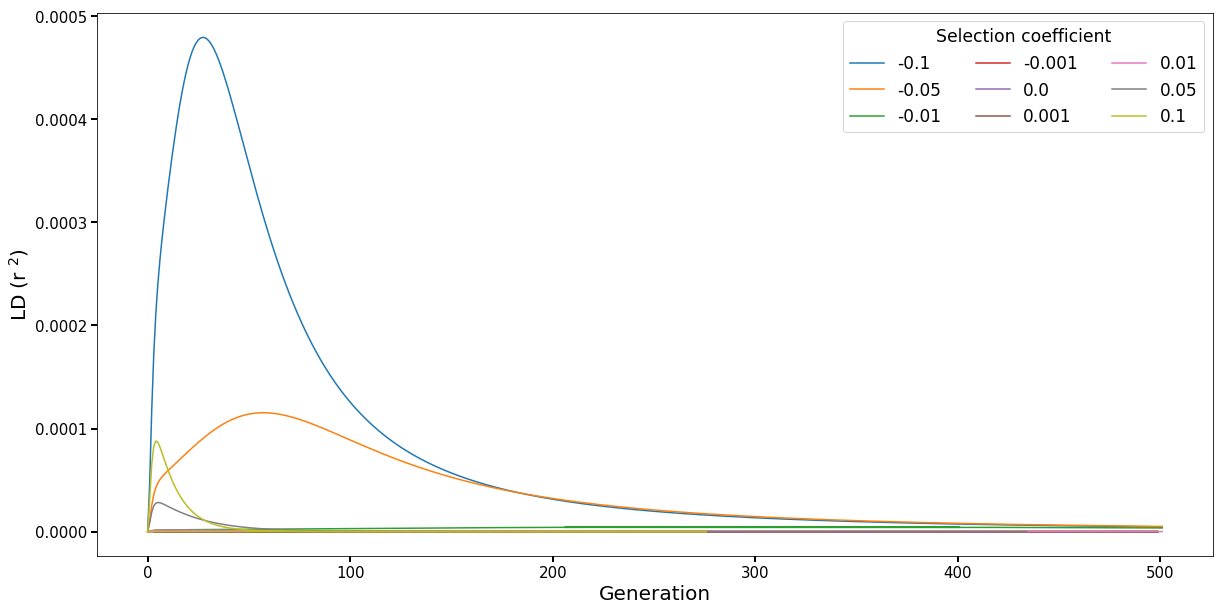

In [14]:
# Plot LD results

groups = data.groupby('sel')

LD_Sel, ax = plt.subplots(figsize=(20, 10))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.generation, group.r_squared, marker='', linestyle='-', ms=12, label=name)
legend = ax.legend(numpoints=1, loc='upper right', prop={'size': 17}, ncol = 3, title = 'Selection coefficient')
plt.setp(legend.get_title(), fontsize='xx-large')
ax.set_xlabel('Generation', fontsize = 20)
ax.set_ylabel('LD (r $\mathregular{^2}$)', fontsize = 20)
ax.tick_params(direction='out', length=6, width=2, colors='black', labelsize = 15)

plt.show()

In [63]:
import os

os.chdir("/Users/jamessantangelo/Documents/Academia/Doctorate_PhD/Projects/SEC_Simulating.evolutionary.clines/SEC_Git/figures")

LD_Sel.savefig("LD_Sel.pdf", dpi=600, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

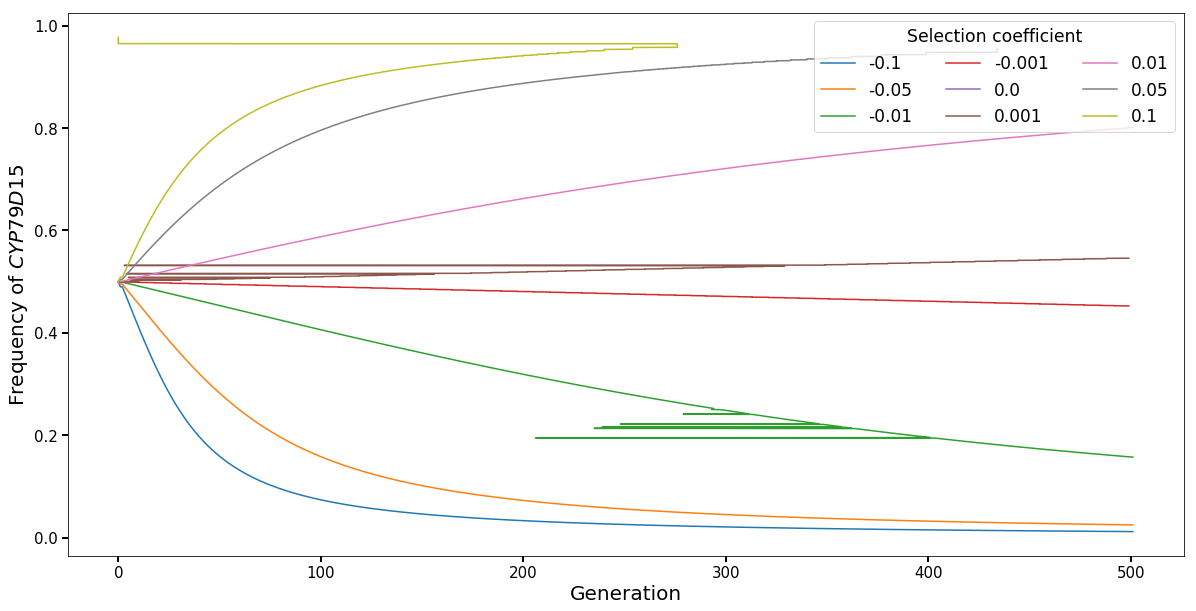

In [16]:
### SOMETHING WEIRD HAPPENING WITH PLOTS BELOW. DATA IS GOOD BUT PLOT IS FUNKY. ###

groups = data.groupby('sel')

fig, ax = plt.subplots(figsize=(20, 10))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.generation, group.pA, marker='', linestyle='-', ms=12, label=name)
legend = ax.legend(numpoints=1, loc='upper right', prop={'size': 17}, ncol = 3, title = 'Selection coefficient')
plt.setp(legend.get_title(), fontsize='xx-large')
ax.set_xlabel('Generation', fontsize = 20)
ax.set_ylabel("Frequency of $\it{CYP79D15}$", fontsize = 20)
ax.tick_params(direction='out', length=6, width=2, colors='black', labelsize = 15)

plt.show()

In [ ]:
os.chdir("/Users/jamessantangelo/Documents/Academia/Doctorate_PhD/Projects/SEC_Simulating.evolutionary.clines/SEC_Git/figures")

CYP_Gen_Sel_LD.savefig("CYP_Gen_Sel_LD.pdf", dpi=600, facecolor='w', edgecolor='w',
        orientation='landscape', papertype=None, format='pdf',
        transparent=False, bbox_inches=None, pad_inches=0.1,
        frameon=None)

notice how it doesn't go to 0/1?

if HCN is good q^2 is tiny  
if ACN is good one dominant locus is irrelev


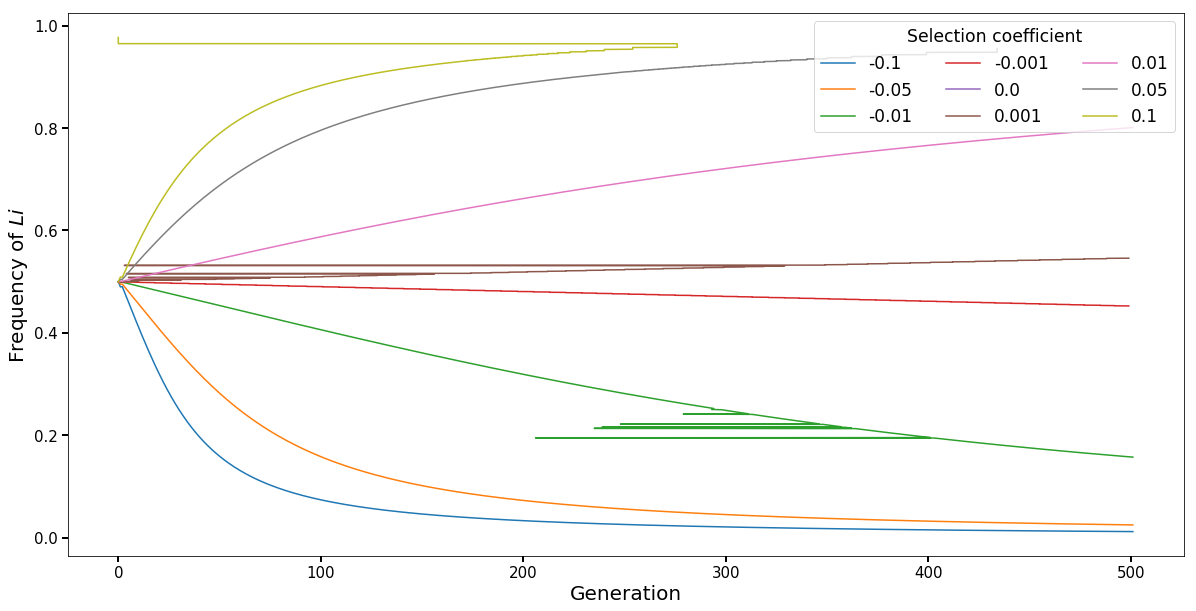

In [61]:
groups = data.groupby('sel')

fig, ax = plt.subplots(figsize=(20, 10))
ax.margins(0.05)
for name, group in groups:
    ax.plot(group.generation, group.pB, marker='', linestyle='-', ms=12, label=name)
legend = ax.legend(numpoints=1, loc='upper right', prop={'size': 17}, ncol = 3, title = 'Selection coefficient')
plt.setp(legend.get_title(), fontsize='xx-large')
ax.set_xlabel('Generation', fontsize = 20)
ax.set_ylabel("Frequency of $\it{Li}$", fontsize = 20)
ax.tick_params(direction='out', length=6, width=2, colors='black', labelsize = 15)

plt.show()

In [11]:
mean_fitness(Genotypes)

1.05625

In [105]:
pA = 0.5
pB = 0.5
qA = 1 - pA
qB = 1 - pB
s = -0.01

Genotypes = HW_genotypes(pA, pB, s, 1)

Gametes = {'AB': pA * pB,
           'Ab': pA * qB,
           'aB': qA * pB,
           'ab': qA * qB}

marg_fit = {'{0}'.format(key1): [] for key1 in Gametes.keys()}
for i in Gametes.keys():
    for j in Genotypes.keys():
        if i == j.split("_")[0]:
            marg_fit[i].append(Genotypes[j][1] * Gametes[j.split("_")[1]])
for i, v in marg_fit.items():
    marg_fit[i] = sum(v)

In [110]:
E1 = 0 - 0 - 0 + s
E2 = 0 - 0 - 0 + s
E3 = 0 - s - 0 + s
E4 = s - s - s + s

Epistasis = [E1, E2, E3, E4]
Epistasis

[-0.01, -0.01, 0.0, 0.0]

In [108]:
Z_lower = (0.5 + min(Epistasis)) / 0.5
Z_upper = 0.5 / (0.5 - max(Epistasis))
(Z_lower, Z_upper)

(0.98, 1.0)

In [29]:
for key, value in Genotypes.items():
    value.append(value[0] * value[1] / mean_fitness(Genotypes))

In [23]:
Genotypes

{'AB_AB': [0.0625, 0.9, 0.059602649006622516],
 'AB_Ab': [0.0625, 0.9, 0.059602649006622516],
 'AB_aB': [0.0625, 0.9, 0.059602649006622516],
 'AB_ab': [0.0625, 0.9, 0.059602649006622516],
 'Ab_AB': [0.0625, 0.9, 0.059602649006622516],
 'Ab_Ab': [0.0625, 1, 0.0662251655629139],
 'Ab_aB': [0.0625, 0.9, 0.059602649006622516],
 'Ab_ab': [0.0625, 1, 0.0662251655629139],
 'aB_AB': [0.0625, 0.9, 0.059602649006622516],
 'aB_Ab': [0.0625, 0.9, 0.059602649006622516],
 'aB_aB': [0.0625, 1, 0.0662251655629139],
 'aB_ab': [0.0625, 1, 0.0662251655629139],
 'ab_AB': [0.0625, 0.9, 0.059602649006622516],
 'ab_Ab': [0.0625, 1, 0.0662251655629139],
 'ab_aB': [0.0625, 1, 0.0662251655629139],
 'ab_ab': [0.0625, 1, 0.0662251655629139]}